In [1]:
%pylab inline
import numpy as np
import pycuda.autoinit
import pycuda.driver as drv
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import cv2
from PatchMatchCuda import PatchMatch

Populating the interactive namespace from numpy and matplotlib


In [9]:
x = cv2.imread("../../data/raw/ava.png")
y = cv2.imread("../../data/raw/ann.jpg")
z = cv2.imread("../../data/raw/aa2.jpg")

x = cv2.resize(x,(224,224))
y = cv2.resize(y,(224,224))
z = cv2.resize(z,(448,448))


x = (x/255).astype(np.float32)
y = (y/255).astype(np.float32)
z = (z/255).astype(np.float32)



called


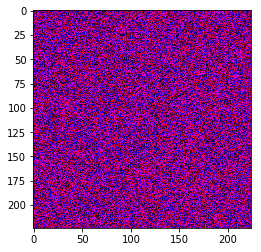

In [10]:
pm = PatchMatch(x,x,y,y, 3)
plt.imshow(pm.visualize())

In [11]:
pm.propagate(iters=10,rand_search_radius=224)

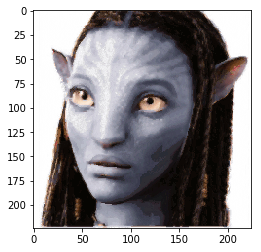

In [12]:
plt.imshow(pm.reconstruct_avg(img=y,patch_size=1)[:,:,::-1])

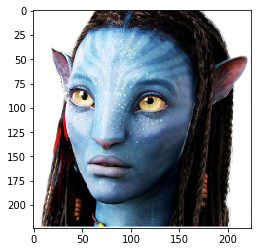

In [13]:
plt.imshow(x[:,:,::-1])

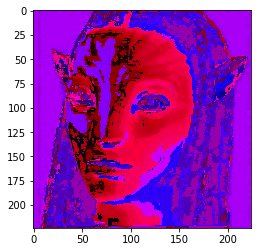

In [14]:
plt.imshow(pm.visualize())